___
# Classification of ED triage notes for self-harm
___

In [1]:
import pandas as pd
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import make_pipeline
from sklearn.metrics import *

# from lime import lime_text

# Project imports
from self_harm_triage_notes.config import *
from self_harm_triage_notes.dev_utils import get_vectorizer

# Toolbox imports
from ml_health_toolbox.dev_utils import *
from ml_health_toolbox.eval_utils import *

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
# Development data
dev_data_filename = "rmh_2012_2017_dev"

# Unseen data
test_data_filename = "rmh_2012_2017_test"

___
## Data preparation
### Load data

In [3]:
df = pd.read_parquet(proc_data_dir / (dev_data_filename + "_normalised.parquet"), engine="pyarrow")
df = df[df.year <= 2017].copy()
print(df.shape)
df.head()

(319288, 19)


,uid,sex,age,arrival_method,arrival_date,year,triage_note,SH,SI,AOD_OD,audit_case,source_system,quarter,length,val_fold,preprocessed_triage_note,tokenized_triage_note,normalised_triage_note,entities
0,RMH-1,female,64.0,other,2012-01-08 00:35:00,2012,"SOB for 5/7, been to GP given prednisolone, co...",Negative,Negative,Negative,NaN,Symphony,2012Q1,140,4,sob for 5/7 been to gp given prednisolone coug...,sob for 5/7 been to gp given prednisolone coug...,sob for 5/7 been to gp given prednisolone coug...,sob for been to gp given prednisolone coughing...
1,RMH-2,male,31.0,other,2012-01-08 00:41:00,2012,"pt has lac down right forehead, to eyebrow, wi...",Negative,Negative,Negative,NaN,Symphony,2012Q1,107,1,pt has lac down right forehead to eyebrow will...,pt has lac down right forehead to eyebrow will...,pt has lac down right forehead to eyebrow will...,pt has lac down right forehead to eyebrow will...
2,RMH-3,male,19.0,road ambulance,2012-01-08 00:52:00,2012,"pt expect MBA, trapped for 45mins, #right femu...",Negative,Negative,Negative,NaN,Symphony,2012Q1,74,1,pt expect mba trapped for 45mins fracture righ...,pt expect mba trapped for 45 mins fracture rig...,pt expect mba trapped for 45 mins fracture rig...,pt expect mba trapped for mins fracture right ...
3,RMH-5,female,25.0,other,2012-01-08 01:23:00,2012,generalised abdo pain and associated headache ...,Negative,Negative,Negative,NaN,Symphony,2012Q1,196,5,generalised abdo pain and associated headache ...,generalised abdo pain and associated headache ...,generalised abdo pain and associated headache ...,generalised abdo pain and associated headache ...
4,RMH-6,female,18.0,other,2012-01-08 01:37:00,2012,abdo pain associated with constipation. Pt se...,Negative,Negative,Negative,NaN,Symphony,2012Q1,134,5,abdo pain associated with constipation. pt see...,abdo pain associated with constipation . pt se...,abdo pain associated with constipation . pt se...,abdo pain associated with constipation pt seen...


In [4]:
# Set-up
label = 'SH'
features = 'entities'
class_names = ("Controls", "Self-harm")
palette = None
    
# Undersampling
undersample = False
n_controls = 10000

# Parameters of feature extraction
vectorizer_mode = "select features"
params = {'analyzer': "word",
          'ngram_range': (1,1),
          'use_idf': True,
          'min_df': 10,
          'mode': "select by pvalue",
          'thresh': 0.001}

reduce_dim = False
lsa_method = 'svd'
n_components = 100

add_length = False # no effect

add_metadata = False

In [5]:
# (Optional)
# Concatenate with sex,age,arrival mode
if add_metadata:
    df[features] = df.apply(lambda x: " ".join(x[['concepts', 'sex', 
                                                  'age','arrival_mode']].astype(str)), axis=1)
    
# Perform undersampling
if undersample:
    df = pd.concat([df[df.SH == 0].sample(n_controls, random_state=42), 
                    df[df.SH!=0]], axis=0)

In [6]:
# Rename label column
df.rename(columns={label: 'y'}, inplace=True)

# Define features and labels
X = df[features]
y = df.y.cat.codes

df.y.value_counts(normalize=True).sort_index().round(4)*100

y
Negative    98.65
Positive     1.35
Name: proportion, dtype: float64

___
# Model selection

### Overfitting: feature selection vs. classifier

In [ ]:
# Fit vectorizer to the full development set
vectorizer = get_vectorizer(vectorizer_mode, params)
vectorizer.fit(X,y)
print("Vectorizer selected %d features." % vectorizer.df_features.shape[0])

# Save the vectorizer
with open(models_dir / (dev_data_filename + "_vectorizer.pickle"), 'wb') as f:
    pickle.dump(vectorizer, f)
 
# List selected features
selected_features = vectorizer.df_features.feature.tolist() #vectorizer.vectorizer.get_feature_names_out()
print(len(selected_features))

# Write the list of selected features
with open(models_dir / (dev_data_filename + "_selected_fts.txt"), 'w') as f:
    f.writelines('\n'.join(selected_features))

### Quick & dirty trying a few algorithms

In [ ]:
vectorizer = get_vectorizer(vectorizer_mode, params)

clfs = (
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42),
#     RandomForestClassifier(class_weight="balanced", random_state=42),
#     GradientBoostingClassifier(random_state=42),
#     XGBClassifier(objective='binary:logistic', random_state=42),
    LGBMClassifier(random_state=42),
)

for clf in clfs:
    pipe = make_pipeline(vectorizer, clf)
    score_cv(pipe, X, y, groups=None, n_splits=N_SPLITS)

### Proper model comparison with nested CV 

> Nested CV is done with 10-fold outer and 3-fold inner splits. Too expensive given the amount of data (~300k documents).

### Tune LightGBM

In [16]:
vectorizer = get_vectorizer(vectorizer_mode, params)
clf = LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)
pipe = make_pipeline(vectorizer, clf)

In [17]:
from scipy.stats import uniform

colsample_bytree = uniform(0.5, 1.0) #[1.0] #uniform(0.1, 0.3) #[0.1, 0.4, 0.7, 1.0]
learning_rate = [0.1] #[0.1] #[0.0001, 0.001, 0.01, 0.1, 0.25, 0.5]
max_depth = range(5, 8) #range(5, 10) #[-1, 3, 4, 5, 6, 7, 10]
min_child_samples = range(1, 10) #range(1, 10) #range(1, 30) #[5, 10, 20, 30, 50] #[5, 20, 100, 500, 1000, 5000]
n_estimators = [300, 350, 400, 450, 500] #[400, 450, 500, 550, 600] #[300, 350, 400, 450, 500] #[100, 200, 300, 400, 500]
num_leaves = range(25, 40) #range(30, 70) #range(15, 20) #range(5, 50) #[5, 10, 30, 50, 100]
reg_alpha = uniform(0.0, 1.0)#uniform(0.5, 0.5) #uniform(0.5, 1.0)
reg_lambda = uniform(0.0, 1.0)#uniform(0.25, 0.75) #uniform(0.0, 1.0) 
subsample = uniform(0.7, 1.0) #[1.0] #uniform(0.45, 0.1) #uniform(0.4, 0.3) #[0.4, 0.7, 1.0]

param_grid = {
    "lgbmclassifier__num_leaves": num_leaves,
    "lgbmclassifier__max_depth": max_depth,
    "lgbmclassifier__learning_rate": learning_rate,
    "lgbmclassifier__n_estimators": n_estimators,
    "lgbmclassifier__min_child_samples": min_child_samples,
    "lgbmclassifier__subsample": subsample,
    "lgbmclassifier__colsample_bytree": colsample_bytree,
    "lgbmclassifier__reg_alpha": reg_alpha,
    "lgbmclassifier__reg_lambda": reg_lambda,
}

search_result = search_params(pipe, 'random', param_grid, X, y, verbose=False)

/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.h

Best for current fold: 0.852 using {'lgbmclassifier__colsample_bytree': 0.6433690283753833, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 6, 'lgbmclassifier__min_child_samples': 2, 'lgbmclassifier__n_estimators': 450, 'lgbmclassifier__num_leaves': 38, 'lgbmclassifier__reg_alpha': 0.9565814142147878, 'lgbmclassifier__reg_lambda': 0.7517940903509635, 'lgbmclassifier__subsample': 0.7561273038509595}


In [15]:
search_result

{'lgbmclassifier__colsample_bytree': 0.8714878757084883,
 'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': 7,
 'lgbmclassifier__min_child_samples': 5,
 'lgbmclassifier__n_estimators': 400,
 'lgbmclassifier__num_leaves': 35,
 'lgbmclassifier__reg_alpha': 0.08036969290255724,
 'lgbmclassifier__reg_lambda': 0.5523167692701669,
 'lgbmclassifier__subsample': 0.8471931076879196}

### Initialise the best model

In [18]:
best_params = search_result
# best_params = {
#     'lgbmclassifier__colsample_bytree': 0.7,
#     'lgbmclassifier__learning_rate': 0.1,
#     'lgbmclassifier__max_depth': 7,
#     'lgbmclassifier__min_child_samples': 6,
#     'lgbmclassifier__n_estimators': 500,
#     'lgbmclassifier__num_leaves': 30,
#     'lgbmclassifier__reg_alpha': 0.07354990891456814,
#     'lgbmclassifier__reg_lambda': 0.9946541510778684,
#     'lgbmclassifier__subsample': 0.47803307025454944
#  }

vectorizer = get_vectorizer(vectorizer_mode, params)
clf = LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)
pipe = make_pipeline(vectorizer, clf)

best_model = pipe.set_params(**best_params)#(**search_result.best_params_)
best_model

,steps,"[('featureselector', ...), ('lgbmclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,boosting_type,'gbdt'
,num_leaves,38
,max_depth,6
,learning_rate,0.1
,n_estimators,450
,subsample_for_bin,200000
,objective,None


___
# Model evaluation
### Evaluate the final model using CV

In [19]:
# Model performance in each CV fold
score_cv(best_model, X, y, groups=None, n_splits=N_SPLITS)

# Make predictions for each CV fold
y_proba = predict_cv(best_model, X, y, groups=None, n_splits=N_SPLITS)

/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.h

________________________________________________________________________________
Training with 5-fold cross-validation:
LGBMClassifier(colsample_bytree=0.6433690283753833, force_row_wise=True,
               max_depth=6, min_child_samples=2, n_estimators=450,
               num_leaves=38, random_state=42, reg_alpha=0.9565814142147878,
               reg_lambda=0.7517940903509635, subsample=0.7561273038509595,
               verbose=-1)
train time: 19.368s
Average precision score: 0.847 (+/- 0.01)
ROC AUC score: 0.991 (+/- 0.00)



/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.h

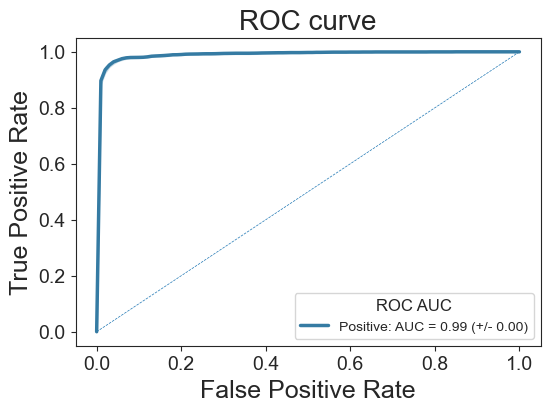

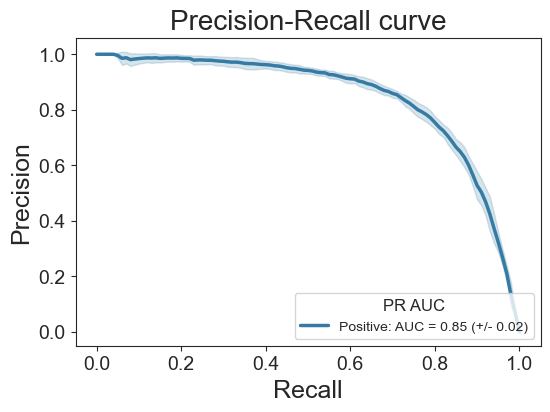

In [20]:
# Plot PR/ROC curves for each CV fold
plot_diagnostic_curves(df.set_index('val_fold').y, y_proba, palette=palette, results_dir=results_dir, filename=label+" lgbm CV")

### Calibration

/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

________________________________________________________________________________
Training with 5-fold cross-validation:
CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('featureselector',
                                                  <self_harm_triage_notes.dev_utils.FeatureSelector object at 0x368f97e50>),
                                                 ('lgbmclassifier',
                                                  LGBMClassifier(colsample_bytree=0.6433690283753833,
                                                                 force_row_wise=True,
                                                                 max_depth=6,
                                                                 min_child_samples=2,
                                                                 n_estimators=450,
                                                                 num_leaves=38,
                                                                 random_st

/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.

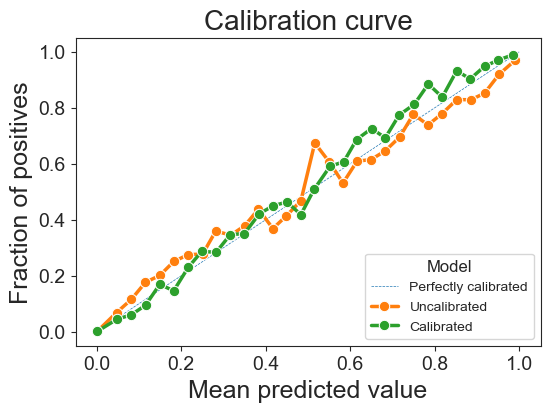

In [21]:
# Calibrate the best model
calibrated_model, y_proba_calibrated = calibrate_cv(best_model, X, y, groups=None, n_splits=N_SPLITS)

# Evaluate the calibrated model
plot_calibration_curve(y, y_proba, y_proba_calibrated, results_dir=results_dir, filename=label+" lgbm CV")

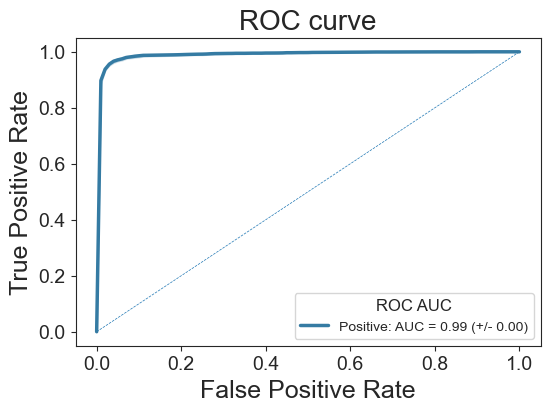

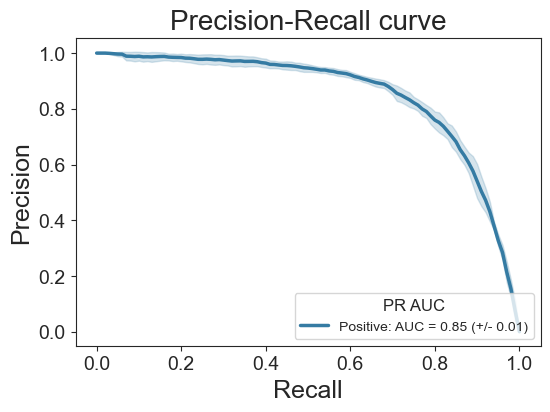

In [22]:
# Plot PR/ROC curves for each CV fold
plot_diagnostic_curves(df.set_index('val_fold').y, y_proba_calibrated, palette=palette, results_dir=results_dir, filename=label+" calibrated lgbm CV")

In [23]:
# The calibrated model is better than uncalibrated
y_proba = y_proba_calibrated
best_model = calibrated_model

### Threshold

In [24]:
if len(df.y.cat.categories)==2:
     # Print optimal thresholds for each CV fold
    threshold_cv(df.set_index('val_fold').y, y_proba[:,1])

    # Find the optimal threshold using aggregated predictions
    thresh = find_optimal_threshold(y, y_proba[:,1])

    # Convert probabilities to class labels
    y_pred = probability_to_label(y_proba, thresh)
else:
    # Convert probabilities to class labels
    y_pred = probability_to_label(y_proba)

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.383, F1-score = 0.785

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.362, F1-score = 0.780

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.398, F1-score = 0.781

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.281, F1-score = 0.793

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.390, F1-score = 0.805

Average optimal threshold: 0.363 (+/- 0.05)
The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.358, F1-score = 0.786



Proportion of labels predicted as:
Negative    0.99
Positive    0.01
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00    314962
    Positive       0.80      0.77      0.79      4326

    accuracy                           0.99    319288
   macro avg       0.90      0.88      0.89    319288
weighted avg       0.99      0.99      0.99    319288

PPV: 0.80, Sensitivity: 0.77, Specificity: 1.00


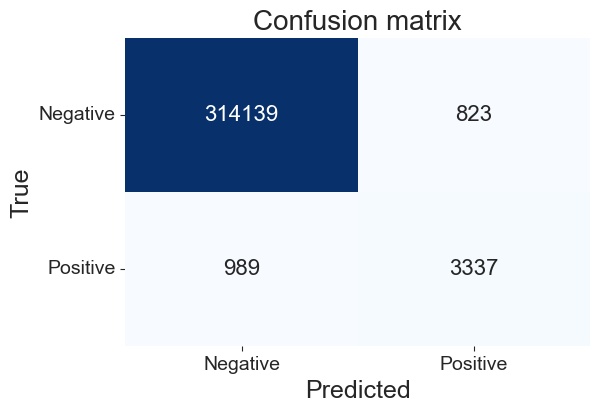

In [25]:
# Evaluate classification using aggregated predictions
evaluate_classification(df.y, y_pred, results_dir, filename=label+" calibrated lgbm CV")

### Train the final model on the full development set

In [26]:
# Re-train the final model on the full training set
best_model.fit(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,estimator,Pipeline(step...verbose=-1))])
,method,'isotonic'
,cv,3
,n_jobs,None
,ensemble,'auto'
,boosting_type,'gbdt'
,num_leaves,38
,max_depth,6
,learning_rate,0.1
,n_estimators,450
,subsample_for_bin,200000


### Test the final model on test data

In [27]:
# Load the test set
df_test = pd.read_parquet(proc_data_dir / (test_data_filename + "_normalised.parquet"), engine="pyarrow")
    
# Concatenate with sex,age,arrival mode
if add_metadata:
    df_test[features] = df_test.apply(lambda x: " ".join(x[['concepts', 'sex', 
                                                            'age','arrival_mode']].astype(str)), axis=1)
    
# Rename label column
df_test.rename(columns={label: 'y'}, inplace=True)

# Define test set features and labels
X_test = df_test[features]
y_test = df_test.y.cat.codes

# Make predictions
y_proba = best_model.predict_proba(X_test)

df_test.y.value_counts(normalize=True).sort_index().round(4)*100

/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/self-harm-triage-notes/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


y
Negative    98.64
Positive     1.36
Name: proportion, dtype: float64

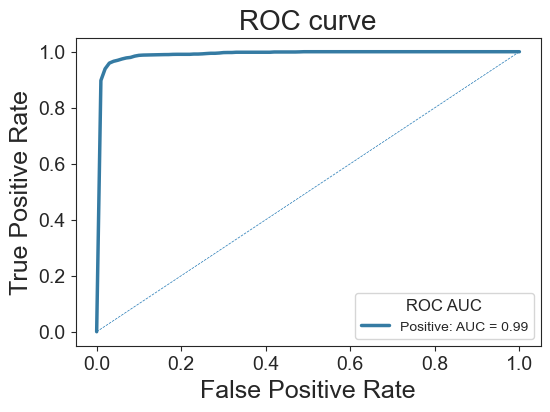

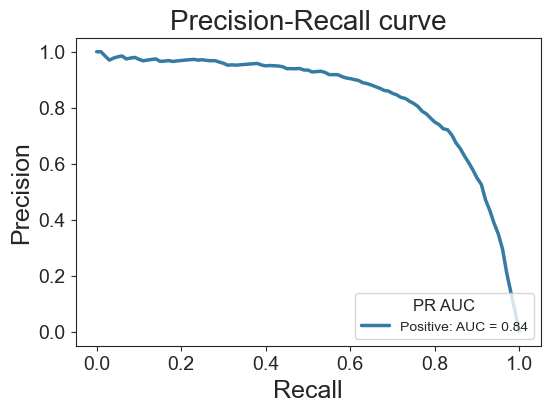

In [28]:
# Plot curves
plot_diagnostic_curves(df_test.y, y_proba, palette=palette, results_dir=results_dir, filename=label+" calibrated lgbm test")

In [29]:
if len(df.y.cat.categories)==2:
    # Convert probabilities to class labels
    y_pred = probability_to_label(y_proba, thresh)
else:
    print("Overall Weighted OvR ROC AUC: %.2f" % roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))
    print("Overall OvR ROC AUC: %.2f" % roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro'))
    
    # Convert probabilities to class labels
    y_pred = probability_to_label(y_proba)

Proportion of labels predicted as:
Negative    0.99
Positive    0.01
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     78741
    Positive       0.78      0.78      0.78      1082

    accuracy                           0.99     79823
   macro avg       0.89      0.89      0.89     79823
weighted avg       0.99      0.99      0.99     79823

PPV: 0.78, Sensitivity: 0.78, Specificity: 1.00


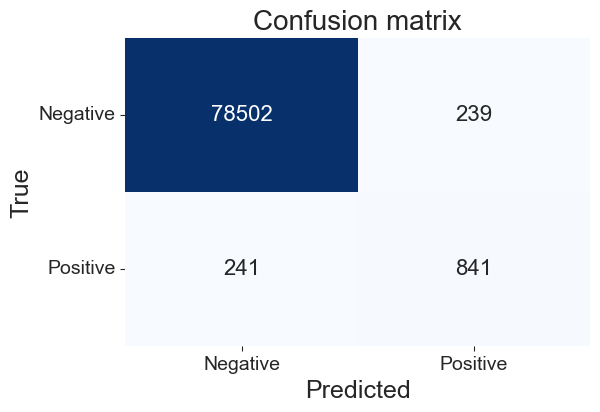

In [30]:
# Evaluate classification
evaluate_classification(df_test.y, y_pred, results_dir, filename=label+" calibrated lgbm test")

### Save the final model and the threshold value

In [31]:
# Save the model
with open(models_dir / (dev_data_filename + "_" + label + "_classifier_amt6.pickle"), 'wb') as f:
    pickle.dump(best_model, f)
    
if len(df.y.cat.categories)==2:
    # Save the threshold
    with open(models_dir / (dev_data_filename + "_" + label + "_thresh_amt6.txt"), 'w') as f:
        f.write(str(thresh)) 